# LLM Agent를 만드는 여정 (4) Langgraph을 활용한 Agent 시스템 설계

## 오늘의 목표 : LangGraph을 활용한 Agent 시스템 설계

이 시리즈의 네 번째 글로, `자동차 사고 접수를 도와주는 챗봇` 시스템을 설계해보도록 하겠습니다. 해당 챗봇은 유저와 대화하며, "사고 시각", "사고 위치", "사고 경위", "사고 범위" 등을 파악하는 시스템입니다.

In [1]:
%%capture
%pip install langgraph

#### Setup

In [228]:
import dotenv
import os
dotenv.load_dotenv("../.env")
if not "OPENAI_API_KEY" in os.environ:
    raise Exception("OPENAI_API_KEY가 환경변수에 존재하지 않습니다.")

#### 모델 불러오기

In [229]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

### Langchain으으로 `자동차 사고 접수를 도와주는 챗봇` 구성하기

자동차 사고 접수 데이터는 아래와 같다고 해봅시다.

In [230]:
from datetime import date, time
from typing import Optional, Union
from pydantic import BaseModel, Field

class AccidentRegistrationInfo(BaseModel):
    """ 사고 등록시 필요한 필수 정보 """
    acc_date: date = Field(..., description="사고가 발생한 일자")
    acc_time: time = Field(..., description="사고가 발생한 시각")
    location: str = Field(..., description="사고가 발생한 위치")
    reason: str = Field(..., description="사고가 발생한 이유에 대한 자세한 설명")

유저가 한 번에 4가지 정보를 맞춰 대답하지 않을 수 있습니다. 이 경우에는 Agent가 추가적인 질문을 해서 유저로부터 답변을 이끌어내야 합니다. 이를 위한 스키마는 아래와 같습니다.

In [231]:
class AdditionalQuestion(BaseModel):
    """ 사고 등록 시 필요한 정보를 유저에게 요청 """
    question: str = Field(...,description="사고 접수 시 필요한 정보를 요청하기 위한 추가적인 질문")

두가지 응답값이 동시에 존재하는 경우에는 아래와 같이 Union을 통해 묶을 수 있습니다.

In [232]:
class AccidentChatBotResponse(BaseModel):
    """ 챗봇의 응답값으로, 사고 등록 시 필요한 정보가 부족한 경우, 사고 등록 시 필요한 필수 정보를 추가적으로 유저에게 질문하고, 사고 등록 시 필요한 필수 정보를 받환 받으면 유저에게 보여준 후 종료합니다.
    """
    response: Union[AdditionalQuestion, AccidentRegistrationInfo] =  Field(..., description="챗봇의 응답")

accident_llm = llm.with_structured_output(AccidentChatBotResponse)

#### 사고접수를 위한 프롬프트 디자인 

유저로부터 사고 접수를 위한 주요정보를 얻어내기 위해 아래와 같이 시스템 프롬프트를 작성했습니다.

In [235]:
from datetime import datetime
from langchain.schema import AIMessage, HumanMessage, SystemMessage
from langchain.prompts import SystemMessagePromptTemplate, ChatPromptTemplate

system_prompt = SystemMessagePromptTemplate.from_template(
    "당신은 자동차 사고 접수를 도와주는 Agent입니다. 유저에게 사고 접수를 위한 필수 정보를 요청하고, 응답받은 후 정리해 주세요.\n\n"
    "필수 정보 \n"
    "- 사고가 발생한 일자\n"
    "- 사고가 발생한 시각\n"
    "- 사고가 발생한 위치\n"
    "- 사고가 발생한 이유\n\n"
    "참고사항 \n"
    "- 한번에 하나씩 질문해 주세요.\n"
    "- 모든 정보를 확보하면, 필수 정보를 정리해 주세요."
    "- 오늘, 어제와 같은 상대적인 시간 표현을 하면, 현재 시각({now})을 기준으로 계산해 주세요."
    "- 위 4가지의 필수 정보는 누락되면 안됩니다.\n"
)
ai_message = AIMessage(content="안녕하세요! 자동차 접수를 도와드리겠습니다. 언제 사고가 발생하셨나요?")

#### 채팅 시스템 작성하기

Langchain을 활용해서 우리는 간단하게 아래와 같이 작성할 수 있습니다. Agent는 유저에게서 사고 접수에 필요한 정보를 요청하여, 총 4가지 요소 (일자 / 시각 / 위치 / 원인)을 확보합니다.  그리고 4가지 정보 모두 확보한 경우, 사고 접수 기록이 완료되면, 접수 기록을 출력하고 종료합니다.

In [236]:
system_message = system_prompt.format_messages(now=datetime.now())
chat_history = [*system_message, ai_message]

while True:
    last_message = chat_history[-1]
    last_message.pretty_print()
    
    input_message = input("고객: ")
    human_message = HumanMessage(content=input_message)
    chat_history.append(human_message)

    resp = accident_llm.invoke(chat_history)
    if isinstance(resp.response, AdditionalQuestion):
        # 추가 질문이 있는 경우
        chat_history.append(AIMessage(content=resp.response.question))
    else:
        # 추가 질문이 없는 경우
        break


print("사고 접수가 완료되었습니다.")
print("==================================")
print("사고 일자 : ", resp.response.acc_date)
print("사고 시각 : ", resp.response.acc_time)
print("사고 위치 : ", resp.response.location)
print("사고 원인 : ", resp.response.reason)

================================== Ai Message ==================================

안녕하세요! 자동차 접수를 도와드리겠습니다. 언제 사고가 발생하셨나요?


고객:  어제 7시에 발생했어요


================================== Ai Message ==================================

사고가 발생한 위치는 어디인가요?


고객:  신림역 부근이요


================================== Ai Message ==================================

사고가 발생한 이유는 무엇인가요?


고객:  빨간불인데, 뒤에서 SUV가 박았어요. 


사고 접수가 완료되었습니다.
사고 일자 :  2024-10-03
사고 시각 :  19:00:00
사고 위치 :  신림역 부근
사고 원인 :  빨간불인데, 뒤에서 SUV가 박았어요.


위와 같은 Agent 시스템을 LangGraph을 통해 보다 구조화해보도록 하겠습니다.

## Langgraph로 Agent 시스템 재구성하기

위와 같이 LLM 모델과 대화를 이어나가기 위해서는, **이전의 대화 기록**을 저장해두어야 합니다. LLM은 자체적으로 기억하는 능력이 없기 때문에, 대화를 이어나가기 위해서는 이전 대화 정보를 항상 같이 보내주어야 하기 때문입니다.

대화 기록(`messages`)와 같은 정보들을 우리는 보통 **상태 정보(state)** 라 합니다. 대화를 한다는 것은 대화 기록에 메시지를 추가하는 "상태 변경"과 같습니다.

Langgraph는 Langchain과 달리 상태를 관리하고, 상태에 따라 서로 다른 액션을 수행할 수 있는 프로그램을 설계하는 프레임워크입니다.

In [210]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    messages: Sequence[BaseMessage]
    info: AccidentRegistrationInfo

# Agent를 만들기 위한 Builder 구성
builder = StateGraph(AgentState)

우선 위와 같이 간단한 AgentState를 정의하고, 이를 기반한 StateGraph를 선언하겠습니다. 

### Node : Agent의 작업을 처리하는 함수

노드는 Agent 시스템에서 실제 작업을 수행하는 부분으로, 현재의 `State`를 입력값으로 받아서 일련의 처리 후, 수정된 `State`를 반환하는 함수 입니다.

#### Initial Prompt 노드: 첫 대화와 맥락 정보를 담음

In [211]:
class InitialPromptNode:
    def __init__(self):
        self.prompt = SystemMessagePromptTemplate.from_template(
            "당신은 자동차 사고 접수를 도와주는 Agent입니다. 유저에게 사고 접수를 위한 필수 정보를 요청하고, 응답받은 후 정리해 주세요.\n\n"
            "필수 정보 \n"
            "- 사고가 발생한 일자\n"
            "- 사고가 발생한 시각\n"
            "- 사고가 발생한 위치\n"
            "- 사고가 발생한 이유\n\n"
            "참고사항 \n"
            "- 한번에 하나씩 질문해 주세요.\n"
            "- 모든 정보를 확보하면, 필수 정보를 정리해 주세요."
            "- 오늘, 어제와 같은 상대적인 시간 표현을 하면, 현재 시각({now})을 기준으로 계산해 주세요."
            "- 위 4가지의 필수 정보는 누락되면 안됩니다.\n"
        )
        self.ai_message = AIMessage(content="안녕하세요! 자동차 접수를 도와드리겠습니다. 언제 사고가 발생하셨나요?")        
    
    def __call__(self, state: AgentState) -> AgentState:
        initial_messages = [
            *self.prompt.format_messages(now=datetime.now()),
            self.ai_message
        ]
        return {
            "messages": initial_messages
        }

builder.add_node(InitialPromptNode()) # node_name: InitialPromptNode

#### LLM 노드 : 대화를 통해, 사고 접수에 필요한 정보를 되물음

In [212]:
class LLMNode:
    """ LLM을 통해, 대화 정보를 가져오는 노드"""
    def __init__(self, llm):
        self.llm  = llm.with_structured_output(AccidentChatBotResponse)

    def __call__(self, state: AgentState) -> AgentState:
        curr_messages = state['messages']
        message = self.llm.invoke(curr_messages)
        if isinstance(message.response, AccidentRegistrationInfo):
            # 모든 데이터 수집이 종료된 경우
            return {
                "info": message.response
            }
        else:
            # 추가적인 질문이 발생한 케이스
            curr_messages.append(AIMessage(content=message.response.question))
            return {
                "messages": curr_messages
            }

llm_node = LLMNode(llm)
builder.add_node(llm_node) # node_name: LLMNode

#### TextInput 노드 : 대화 입력창을 담당

In [213]:
class TextInputNode:

    def __call__(self, state: AgentState) -> AgentState:
        curr_messages = state['messages']
        
        last_message = curr_messages[-1]
        last_message.pretty_print()
        
        message = HumanMessage(content=input("사용자 : "))
        curr_messages.append(message)
        return {
            "messages": curr_messages
        }

builder.add_node(TextInputNode())

In [214]:
class SummaryNode:
    def __call__(self, state: AgentState):
        info = state.get('info')
        
        print("사고 접수가 완료되었습니다.")
        print("==================================")
        print("사고 일자 : ", info.acc_date)
        print("사고 시각 : ", info.acc_time)
        print("사고 위치 : ", info.location)
        print("사고 원인 : ", info.reason)        


builder.add_node(SummaryNode())

### Edge: Agent의 작업 흐름을 결정하는 부분

Edge는 Agent 시스템에서 각 노드의 작업 흐름을 결정합니다. START, END를 통해 작업의 시작과 끝을 지정하고, 노드 간 관계를 설정할수 있습니다.

In [215]:
from langgraph.graph import START, END

In [216]:
builder.add_edge(START, 'InitialPromptNode')
builder.add_edge('InitialPromptNode', 'TextInputNode')
builder.add_edge('TextInputNode', 'LLMNode')
builder.add_edge('SummaryNode', END)

여기서 중요한 것은 agent 봇이 계속 질문이 이어나갈 것인지, 그만할 것인지 판단하는 것입니다. State에서 `info` 필드가 찼다는 것은 이미 필요한 정보를 모두 반영했다는 것을 말하므로, info여부가 None인지를 통해 그만 할것인지 계속 질문할 것인지를 판단하도록 하겠습니다.

In [217]:
def stop_agent_cond(state: AgentState):
    if state.get('info') is not None:
        return 'end'
    else:
        return 'continue'
    
builder.add_conditional_edges('LLMNode', stop_agent_cond, {
     "end": 'SummaryNode',
    "continue": 'TextInputNode'
})

#### 위와 같이 정의한 Graph를 컴파일하기

구조적으로는 아래와 같은 형태를 띕니다.

In [218]:
app = builder.compile()

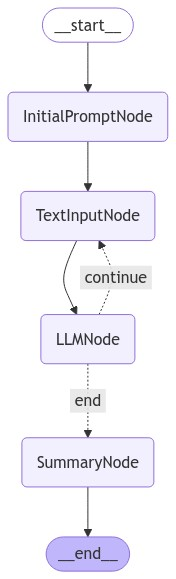

In [219]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

위 코드 실행하기를 실행하면 아래와 같은 간단한 사고 접수 Agent를 설계할 수 있습니다.

In [220]:
for state in app.stream({"messages": []}):
    pass

================================== Ai Message ==================================

안녕하세요! 자동차 접수를 도와드리겠습니다. 언제 사고가 발생하셨나요?


사용자 :  어제 7시요


================================== Ai Message ==================================

사고가 발생한 위치는 어디인가요?


사용자 :  신림역이요


================================== Ai Message ==================================

사고가 발생한 이유는 무엇인가요?


사용자 :  교차로에서 달려오는 오토바이와 박았습니다.


사고 접수가 완료되었습니다.
사고 일자 :  2024-10-03
사고 시각 :  07:00:00
사고 위치 :  신림역
사고 원인 :  교차로에서 달려오는 오토바이와 박았습니다.
